# Análise de Sentimento com RNN


<table>
<tr>
<td>
<img align="middle"  width='400' heith='100'   src='images/rnn_sent.png'>
</td>
</tr>
</table>


Nesse notebook vamos usar um dataset sintético para apreender como realizar análise de sentimento usando uma rede recorrente.

Se você nunca usou a biblioteca [PyTorch](https://pytorch.org/) antes, vale a pena rever os conceitos principais nesses notebooks:

- [PyTorch basico 1](https://github.com/MLIME/MAC0460/blob/master/notebooks/pytorch_basico1.ipynb)

- [PyTorch basico 2](https://github.com/MLIME/MAC0460/blob/master/notebooks/pytorch_basico2.ipynb)



In [1]:
# notebook feito para a versão 0.4.1 

import numpy as np
import pandas as pd
import torch
import re
from torchtext import data
import torch.optim as optim
from plots.plots import plot_confusion_matrix, plot_histogram_from_labels
from text_generation.sentiment import generate_sentiment_data

% matplotlib inline

Vamos usar um dataset bem simples. São sentenças curtas que atribuem um atributo que pode ser negativo ou positivo a uma pessoa:

- **Paula sempre foi curiosa** (positivo)

- **Alberto é prepotente** (negativo)

Para não ser muito simplista também vamos colocar algumas sentenças que são neutras, as vezes elas não são
nem positivas nem negativas, as vezes elas são simplesmente ambíguas:

- **Clara nunca foi esmerada** (neutro)

- **Amanda é tanto carinhosa quanto frívolae** (neutro)

Esse dataset é *sintético*, i.e., ele é gerado automaticamente por meio de um  script. Isso é mais fácil de gerar, mas são dados bem artificiais. Dados reais são mais complexos e possuem maior ruido. 

In [2]:
generate_sentiment_data()

Esses dados estão dividos entre **treino** e **teste**.

In [3]:
train_data_path = 'data/sentiment_train.csv'
test_data_path = 'data/sentiment_test.csv'

train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

In [4]:
train_data.head()

,text,label
0,Manuela nunca foi interesseira,2
1,Benevenuto era benévolo,1
2,Eleutério era proativo,1
3,Valentina é tanto persistente quanto desleixada,2
4,Mirela sempre foi disponível,1


In [5]:
test_data.head()

,text,label
0,Breno era caritativo,1
1,Albano era desumano,0
2,"mesmo que as vezes Lívia é escrupulosa, Lívia ...",0
3,Angelina é tanto sincera quanto narcisista,2
4,Clarisse nunca foi desafiador,2


Vamos colocar as legendas nas etiquetas

In [6]:
labels_legend = ['Negative','Positive', 'Neutral']
sentiment2int = {'Negative':0, 'Positive':1, 'Neutral':2}
int2sentiment = {i[1]: i[0] for i in sentiment2int.items()}
train_labels = train_data["label"].values
test_labels =  test_data["label"].values

Para vermos a distribuição das classes, vamos plotar um histograma. Note que aqui as classes estão balanceadas. Num dataset real de análise de sentimento isso geralmente não acontece. Isso fica claro quando analisamos textos políticos, como [*tweets*](https://www.kaggle.com/crowdflower/first-gop-debate-twitter-sentiment), a grande maioria dos exemplos são de tweets com sentimento negativo. 

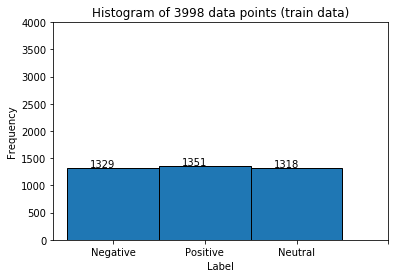

In [7]:
plot_histogram_from_labels(train_labels,
                           labels_legend,
                           "train data")

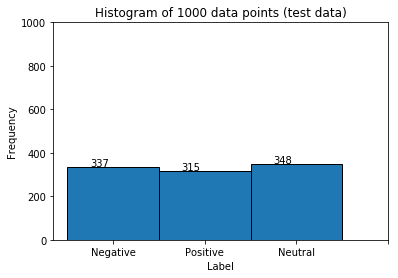

In [8]:
plot_histogram_from_labels(test_labels,
                           labels_legend,
                           "test data")

## Pré-processamento dos dados

Antes de transformar as palavras em índices, vamos **limpar o texto**, i.e. vamos deixar todo o texto em caixa baixa e vamos retirar as pontuações  

In [9]:
def simple_pre_process_text_df(data, field="text"):
    data[field] = data[field].apply(lambda x: x.lower())
    data[field] = data[field].apply(lambda x: re.sub(r'[^\w\s]','',x))

def simple_pre_process_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub(r'[^\w\s]','',sentence)
    return sentence

In [10]:
ints = np.random.randint(0, 100, 10)

print("====Antes do processamento====\n")

for i in ints:
    print(train_data["text"].values[i])

====Antes do processamento====

Afre era grosso
Úrsula nunca foi desonesta
Godofredo não é diligente nem estressado
Agnes sempre foi inflexível
Olívia nunca foi intolerante
Tomé é engraçado
Felismino era sossegado
Estela sempre foi valorosa
Lis é amável, mas as vezes ele parece ser desconfiada
Elis é tanto atenciosa quanto malvada


In [11]:
simple_pre_process_text_df(train_data)
simple_pre_process_text_df(test_data)

In [12]:
print("====Depois do processamento====\n")

for i in ints:
    print(train_data["text"].values[i])

====Depois do processamento====

afre era grosso
úrsula nunca foi desonesta
godofredo não é diligente nem estressado
agnes sempre foi inflexível
olívia nunca foi intolerante
tomé é engraçado
felismino era sossegado
estela sempre foi valorosa
lis é amável mas as vezes ele parece ser desconfiada
elis é tanto atenciosa quanto malvada


Agora vamos salvar o resultado desse procesamento em outro csv:

In [13]:
train_data = train_data[["text", "label"]]
test_data = test_data[["text", "label"]]
train_data.to_csv('data/sentiment_train_clean.csv', header=False, index=False)
test_data.to_csv('data/sentiment_test_clean.csv', header=False, index=False)

Para faciliar a manipulação dos dados vamos usar certas classes do pacote [torchtext](https://torchtext.readthedocs.io/en/latest/index.html). 

Em particular, vamos usar a classe `data.Field` para guadar todos os dados de texto:

> Field class models common text processing datatypes that can be represented
by tensors.  It holds a Vocab object that defines the set of possible values
for elements of the field and their corresponding numerical representations.
The Field object also holds other parameters relating to how a datatype
should be numericalized, such as a tokenization method and the kind of
Tensor that should be produced.

E vamos usar a classe `data.LabelField` para guardar as etiquetas:

> A label field is a shallow wrapper around a standard field designed to hold labels
for a classification task. Its only use is to set the unk_token and sequential to `None` by default.


In [14]:
TEXT = data.Field()
LABEL = data.LabelField(tensor_type=torch.FloatTensor)

Vamos agora criar um dataset usando a classe `data.TabularDataset` passando como referência o dataset processado que acabamos de gerar.

In [15]:
train = data.TabularDataset(path='data/sentiment_train_clean.csv',
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

test = data.TabularDataset(path='data/sentiment_test_clean.csv',
                            format="csv",
                            fields=[('text', TEXT), ('label', LABEL)])

Vamos construir o vocabulário agora, i.e., vamos associar cada palavra a um índice. Note que o texto pode ter um grande número de palavras únicas, vamos deixar que o tamanho máximo do vocabulário seja de 25000 palavras.

In [ ]:
TEXT.build_vocab(train, max_size=25000)
LABEL.build_vocab(train)

In [ ]:
print('len(TEXT.vocab):', len(TEXT.vocab))
print('len(LABEL.vocab):', len(LABEL.vocab))

Printing the 20 most frequent words

In [ ]:
print(TEXT.vocab.freqs.most_common(20))

- `.itos` is the `int2str` method from the object `TEXT.vocab` 
- `.stoi` is the `str2int` method from the object `TEXT.vocab` 

In [ ]:
print("TEXT.vocab.itos")
print("word", "index")

for i, word in enumerate(TEXT.vocab.itos[:10]):
    print(word, i)


print()
print("TEXT.vocab.stoi")
print("word", "index")
for word in "i love trump".split():
    print(word, TEXT.vocab.stoi[word])

Vamos dividir o dataset de treinamento: 80$\%$ dos dados vão ser usados para o treinamento enquanto que 20$\%$ dos dados vão ser usados para validação

In [16]:
train, valid = train.split(0.8)

In [18]:
print('número de dados de treinamento:', len(train))
print('número de dados de validação:', len(valid))
print('número de dados de teste:', len(test))

número de dados de treinamento: 3198
número de dados de validação: 800
número de dados de teste: 1000


In [ ]:
class RNNConfig(object):
    """
    Holds logistic regression model hyperparams.
    
    :param height: image height
    :type heights: int
    :param width: image width
    :type width: int
    :param channels: image channels
    :type channels: int
    :param batch_size: batch size for training
    :type batch_size: int
    :param epochs: number of epochs
    :type epochs: int
    :param save_step: when step % save_step == 0, the model
                      parameters are saved.
    :type save_step: int
    :param learning_rate: learning rate for the optimizer
    :type learning_rate: float
    :param momentum: momentum param
    :type momentum: float
    """
    def __init__(self,
                 vocab_size=25000,
                 batch_size=32,
                 embedding_dim=100,
                 rnn_dim=256,
                 output_dim=3,
                 epochs=3,
                 learning_rate=0.01,
                 momentum=0.1):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.rnn_dim = rnn_dim
        self.output_dim = output_dim
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.momentum = momentum
        

    def __str__(self):
        """
        Get all attributs values.
        :return: all hyperparams as a string
        :rtype: str
        """
        status = "vocab_size = {}\n".format(self.vocab_size)
        status += "batch_size = {}\n".format(self.batch_size)
        status += "embedding_dim = {}\n".format(self.embedding_dim)
        status += "rnn_dim = {}\n".format(self.rnn_dim)
        status += "output_dim = {}\n".format(self.output_dim)
        status += "epochs = {}\n".format(self.epochs)
        status += "learning_rate = {}\n".format(self.learning_rate)
        status += "momentum = {}\n".format(self.momentum)
        return status

Hyperparams

In [ ]:
config = RNNConfig(vocab_size=len(TEXT.vocab), output_dim=len(LABEL.vocab))
print(config)

To define an iterator that batches examples of similar lengths together we use the class `data.BucketIterator`. 


In [ ]:
# train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
# valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
# test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)

class DataHolder():
    """
    Class to store all data using the data.BucketIterator class.

    """
    def __init__(self,
                 config,
                 train,
                 valid,
                 test):        
        self.train_iter = data.BucketIterator(train, batch_size=config.batch_size, repeat=False)
        self.valid_iter = data.BucketIterator(valid, batch_size=config.batch_size, repeat=False)
        self.test_iter = data.BucketIterator(test, batch_size=len(test), repeat=False)
        
        
sent_data = DataHolder(config, train, valid, test) 


We can see some batch examples, here we should remember that the batch shape is `[sent len, batch size]`

In [ ]:
i = np.random.randint(0, config.batch_size)
batch = next(iter(sent_data.train_iter))
print("batch.text.shape = {}".format(batch.text.shape))
print("batch.text.type = {}\n".format(batch.text.type()))

print("batch.label.shape = {}".format(batch.label.shape))
print("batch.label.type = {}\n".format(batch.label.type()))
batch_t = batch.text.transpose(0, 1)
example = batch_t[i]
for i in example:
    print(TEXT.vocab.itos[i], end=" ")

Here we will define the RNN model using the `nn.module` class.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.embedding = nn.Embedding(config.vocab_size, config.embedding_dim)
        self.rnn = nn.RNN(config.embedding_dim, config.rnn_dim)
        self.fc = nn.Linear(config.rnn_dim, config.output_dim)
        
    def forward(self, x):

        #x = [sent len, batch size]
        
        embedded = self.embedding(x)
        
        #embedded = [sent len, batch size, emb dim]
        
        output, hidden = self.rnn(embedded)
        
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]
        return self.fc(hidden.squeeze(0))

    def predict(self, x):
        out = self.forward(x)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

    def evaluate_bach(self, batch):
        prediction = model.predict(batch.text)
        labels = batch.label.type('torch.LongTensor')
        correct = torch.sum(torch.eq(prediction, labels)).float()
        accuracy = float(correct/labels.shape[0])
        return accuracy, prediction, labels
        


In [ ]:
model = RNN(config)

Model's accuracy **before** the training

In [ ]:
test_bach = next(iter(sent_data.test_iter))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

Criando a função para treinar o modelo

In [ ]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        logits = model(batch.text)
        label = batch.label.type("torch.LongTensor")
        loss = criterion(logits, label)
        acc, _, _ = model.evaluate_bach(batch)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc

    mean_loss = epoch_loss / len(iterator)
    mean_acc = epoch_acc / len(iterator)
        
    return mean_loss, mean_acc


def get_valid_loss(model, valid_iter, criterion):
    batch = next(iter(valid_iter))
    model.eval()
    logits = model(batch.text)
    label = batch.label.type("torch.LongTensor")
    loss = criterion(logits, label)
    return loss

def training_loop_text_classification(model, config, dataholder, model_path, verbose=True):
    """
    Train a model for text classification

    :param model: RNN classification model
    :type model: 
    :param config: image classification model
    :type config: LogisticRegression or DFN
    :param dataholder: data
    :type dataholder: DataHolder or DataHolderGentle
    :param model_path: path to save model params
    :type model_path: str
    :param verbose: param to control print
    :type verbose: bool
    """
    optimizer = optim.SGD(model.parameters(),
                          lr=config.learning_rate,
                          momentum=config.momentum)
    
    criterion = nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    criterion = criterion.to(device)
    train_iter = dataholder.train_iter
    valid_iter = dataholder.valid_iter
    
    best_valid_loss = float("inf")
    
    for epoch in range(config.epochs):
        print("epoch = ({}/{})".format(epoch + 1, config.epochs))
        train_loss, train_acc = train(model, train_iter, optimizer, criterion)
        valid_loss = get_valid_loss(model,valid_iter, criterion)
        msg = "\ntrain_loss = {:.3f} | valid_loss = {:.3f}".format(float(train_loss),float(valid_loss))
        if float(valid_loss) < best_valid_loss:
            torch.save(model.state_dict(), model_path)
            best_valid_loss = float(valid_loss)
        if verbose:
            print(msg)
            print("train_acc = {}\n".format(train_acc))    

In [ ]:
config = RNNConfig(vocab_size=len(TEXT.vocab),
                   output_dim=len(LABEL.vocab),
                   epochs=8,
                   learning_rate=0.03)
print(config)

model = RNN(config)

training_loop_text_classification(model, config, sent_data, "rnn.pkl")

Model's accuracy **after** the training

In [ ]:
model = RNN(config)
model.load_state_dict(torch.load('rnn.pkl'))
_, pred, labels = model.evaluate_bach(test_bach)

plot_confusion_matrix(truth=labels.numpy(),
                      predictions=pred.numpy(),
                      save=False,
                      path="rnn_confusion_matrix.png",
                      classes=labels_legend)

Taking a look on some single examples

In [ ]:
t1 = "Rurique era sensível"
t2 = "Nice sempre foi dissimulada"
t3 =  "Betina é tanto ponderada quanto indiferente"
t4 = "Mel parece ser quezilento, mas eu não sei	"
examples = [t1,t2, t3, t4]

In [ ]:
for t in examples:
    print()
    print(t)
    text = simple_pre_process_text(t)
    text_as_int = [TEXT.vocab.stoi[word] for word in text.split(" ")]
    text_as_tensor = torch.Tensor(text_as_int).type('torch.LongTensor')
    text_as_tensor = text_as_tensor.view((1, text_as_tensor.shape[0]))
    text_as_tensor = text_as_tensor.t()  # putting in the format [sent len, batch size]
    pred = int(model.predict(text_as_tensor))
    print(int2sentiment[pred])